## Model iterations with XGBoost

In this notebook we continue our model iterations with ensemble methods using Gradient Bossting Algorithm

Steps:
- run a Vanilla XGBoost model
- run a grid search with sampled training data and find the best hyperparameters
- train xgboost model on training data using identified parameters
- test out each iterations on validation set and train sets.
- pick the best performer make predictions using teh test data.

In [ ]:
#imports
%load_ext autoreload
%autoreload 2

In [6]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import cleaning_functions as cfs
from src import preprocessing_functions as pfs
from src import modeling_functions as mfs
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier 
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import recall_score, f1_score, make_scorer
import xgboost 

In [2]:
df = cfs.cleaned_dataframe()

In [3]:
df.head()

,district_id,vdcmun_id,ward_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,target
building_id,,,,,,,,,,,,,,,,,,,,,
120101000011,12,1207,120703,1,9,288,9,land_surface_condition_flat,foundation_type_other,roof_type_bamboo_or_timber_light_roof,...,0,0,0,0,0,0,0,0,0,2.0
120101000021,12,1207,120703,1,15,364,9,land_surface_condition_flat,foundation_type_other,roof_type_bamboo_or_timber_light_roof,...,0,0,0,0,0,0,0,0,0,3.0
120101000031,12,1207,120703,1,20,384,9,land_surface_condition_flat,foundation_type_other,roof_type_bamboo_or_timber_light_roof,...,0,0,0,0,0,0,0,0,0,1.0
120101000041,12,1207,120703,1,20,312,9,land_surface_condition_flat,foundation_type_other,roof_type_bamboo_or_timber_light_roof,...,0,0,0,0,0,0,0,0,0,1.0
120101000051,12,1207,120703,1,30,308,9,land_surface_condition_flat,foundation_type_other,roof_type_bamboo_or_timber_light_roof,...,0,0,0,0,0,0,0,0,0,1.0


In [4]:
df = df.drop(['vdcmun_id', 'ward_id'], axis=1)

In [5]:
#create target and feature dataframes 
y = df['target']
X = df.drop('target', axis=1)

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2015, test_size = .2)

#train validation split
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, random_state = 2015, test_size = .25)

#stratified sampling to have equal representation of classes
rus = RandomUnderSampler(random_state=2015)
X_tr_res, y_tr_res = rus.fit_resample(X_tr, y_tr)

#One Hot encode all categorical features land_surface_condition,foundation_type, roof_type, ground_floor_type, other_floor_type
X_tr_res, X_val, X_test = pfs.ohe_train_and_test_features(X_tr_res, X_val, X_test)

#One hot encode district_id
X_tr_res, X_val, X_test = pfs.ohe_train_val_test_geos(X_tr_res, X_val, X_test)

In [7]:
X_train_scaled = X_tr_res.copy()
col_names = ['count_floors_pre_eq', 'count_families', 'age_building', 'plinth_area_sq_ft', 'height_ft_pre_eq']
features = X_train_scaled[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

X_train_scaled[col_names] = features
X_train_scaled.head()

,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,...,20,21,22,23,24,28,29,30,31,36
0,-1.536583,0.442693,-1.098342,-1.386090,0,1,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.536583,-0.120057,-0.952638,-1.386090,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.047621,-0.241732,-0.118883,-0.686274,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.047621,-0.089638,0.302041,-0.686274,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.047621,0.016828,-0.471003,0.363450,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [8]:
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

features = X_val_scaled[col_names]
features = scaler.transform(features.values)
X_val_scaled[col_names] = features
features = X_test_scaled[col_names]
features = scaler.transform(features.values)
X_test_scaled[col_names] = features


## GradientBoostingClassifier with XGBoost

In [9]:
xgbc1 = xgboost.XGBClassifier(random_state=2015, objective='multi:softmax', num_class=3)
xgbc1.fit(X_train_scaled, y_tr_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=2015, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [10]:
from sklearn.metrics import classification_report

In [39]:
print('Recall Score Class 3 Validation data: ', recall_score(y_val, xgbc1.predict(X_val_scaled), average=None)[2])

Recall Score Class 3 Validation data:  0.6592521655856876


In [42]:
print('Recall Score Class 3 Train data: ', recall_score(y_tr_res, xgbc1.predict(X_train_scaled), average=None)[2])

Recall Score Class 3 Train data:  0.6735893081837839


In [35]:
print('Classification Report for xgbc1, Validation Data','\n',
      '======================================================','\n',
      classification_report(y_val, xgbc1.predict(X_val_scaled)))

Classification Report for xgbc1, Validation Data 
               precision    recall  f1-score   support

         1.0       0.65      0.68      0.67     33118
         2.0       0.30      0.53      0.39     27409
         3.0       0.86      0.66      0.75     91892

    accuracy                           0.64    152419
   macro avg       0.61      0.62      0.60    152419
weighted avg       0.72      0.64      0.67    152419



In [34]:
print('Classification Report for xgbc1, Training Data','\n',
      '======================================================','\n',
      classification_report(y_tr_res, xgbc1.predict(X_train_scaled)))

Classification Report for xgbc1, Training Data 
               precision    recall  f1-score   support

         1.0       0.72      0.70      0.71     81857
         2.0       0.54      0.56      0.55     81857
         3.0       0.68      0.67      0.68     81857

    accuracy                           0.64    245571
   macro avg       0.65      0.64      0.65    245571
weighted avg       0.65      0.64      0.65    245571



As expected, even with a vanilla gradient boosting model, our varaince is low.

We will try a grid search next and see if we can improve our Recall Score for class 3

Here again since we are faced with too many datapoints, we downsample from our training data and run a grid search using 40% of our datapoints.

In [12]:
recall3 = mfs.scorer_recall3()
f13 = mfs.scorer_f13()

In [19]:
param_grid = {
    "learning_rate": [0.1, 0.3],
    'max_depth': [6, 9],
    'n_estimators': [100, 250, 400]
}
xgbc2 = xgboost.XGBClassifier(random_state=2015, objective='multi:softmax', num_class=3)
gs_xgb = GridSearchCV(xgbc2, param_grid=param_grid, scoring=recall3, cv=3, verbose=2)

In [17]:
combined_train = pd.concat([X_train_scaled, y_tr_res], axis=1)
smaller_train = combined_train.sample(frac=0.4, random_state=2015)

In [18]:
X_for_gs = smaller_train.drop('target', axis=1)
y_for_gs = smaller_train['target']

In [20]:
gs_xgb.fit(X_for_gs, y_for_gs)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] . learning_rate=0.1, max_depth=6, n_estimators=100, total=  28.9s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.0s remaining:    0.0s


[CV] . learning_rate=0.1, max_depth=6, n_estimators=100, total=  33.1s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................
[CV] . learning_rate=0.1, max_depth=6, n_estimators=100, total=  34.3s
[CV] learning_rate=0.1, max_depth=6, n_estimators=250 ................
[CV] . learning_rate=0.1, max_depth=6, n_estimators=250, total= 1.4min
[CV] learning_rate=0.1, max_depth=6, n_estimators=250 ................
[CV] . learning_rate=0.1, max_depth=6, n_estimators=250, total= 1.5min
[CV] learning_rate=0.1, max_depth=6, n_estimators=250 ................
[CV] . learning_rate=0.1, max_depth=6, n_estimators=250, total= 1.4min
[CV] learning_rate=0.1, max_depth=6, n_estimators=400 ................
[CV] . learning_rate=0.1, max_depth=6, n_estimators=400, total= 2.3min
[CV] learning_rate=0.1, max_depth=6, n_estimators=400 ................
[CV] . learning_rate=0.1, max_depth=6, n_estimators=400, total= 2.3min
[CV] learning_rate=0.1, max_depth=6, n_estimators=400 ................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 62.0min finished


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, num_class=3,
                                     num_parallel_tree=None,
                                     objective='multi:softmax',
                                     random_state=2015, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight

Even with a smaller dataset our grid search took way too long to run 
>  elapsed: 62.0min finished


In [22]:
gs_xgb.best_params_

{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 400}

Note: our identified hyperparameters are limited to our choice of grid as well as resampled datapoints.
There is certainly room for improvement here.

`best_params` = {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 400}

In [23]:
xgbc3 = xgboost.XGBClassifier(random_state=2015, objective='multi:softmax', num_class=3,
                             learning_rate=0.1, max_depth=6, n_estimators=400)
xgbc3.fit(X_train_scaled, y_tr_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=2015, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [38]:
print('Recall Score Class 3 Validation data: ', recall_score(y_val, xgbc3.predict(X_val_scaled), average=None)[2])

Recall Score Class 3 Validation data:  0.6624189265659688


In [41]:
print('Recall Score Class 3 Train data: ', recall_score(y_tr_res, xgbc3.predict(X_train_scaled), average=None)[2])

Recall Score Class 3 Train data:  0.6820064258401847


In [40]:
print('Recall Score Class 3 Test data: ', recall_score(y_test, xgbc3.predict(X_test_scaled), average=None)[2])

Recall Score Class 3 Test data:  0.6605489633589777


In [29]:
important_features = list(zip(X_train_scaled.columns, xgbc3.feature_importances_))
sorted_features = sorted(important_features, key=lambda x: x[1])

In [30]:
sorted_features

[('has_secondary_use_health_post', 0.00023677255),
 ('has_secondary_use_use_police', 0.00037697976),
 ('plan_configuration_h_shape', 0.00038979464),
 ('plan_configuration_building_with_central_courtyard', 0.0006723942),
 ('has_secondary_use_gov_office', 0.00085543864),
 ('plan_configuration_e_shape', 0.00130705),
 ('plan_configuration_t_shape', 0.0013447456),
 ('has_secondary_use_industry', 0.0013770413),
 ('has_secondary_use_school', 0.0015594284),
 ('position_attached_1_side', 0.001561891),
 ('plan_configuration_u_shape', 0.0015930531),
 ('position_attached_2_side', 0.0016146278),
 ('position_attached_3_side', 0.0016570803),
 ('has_secondary_use_institution', 0.0016736893),
 ('plan_configuration_others', 0.0017330695),
 ('position_not_attached', 0.0019244921),
 ('plan_configuration_rectangular', 0.0020946374),
 ('has_secondary_use_hotel', 0.0022307818),
 ('plan_configuration_l_shape', 0.0022816935),
 ('plinth_area_sq_ft', 0.0023718665),
 ('plan_configuration_square', 0.002491868),
 (

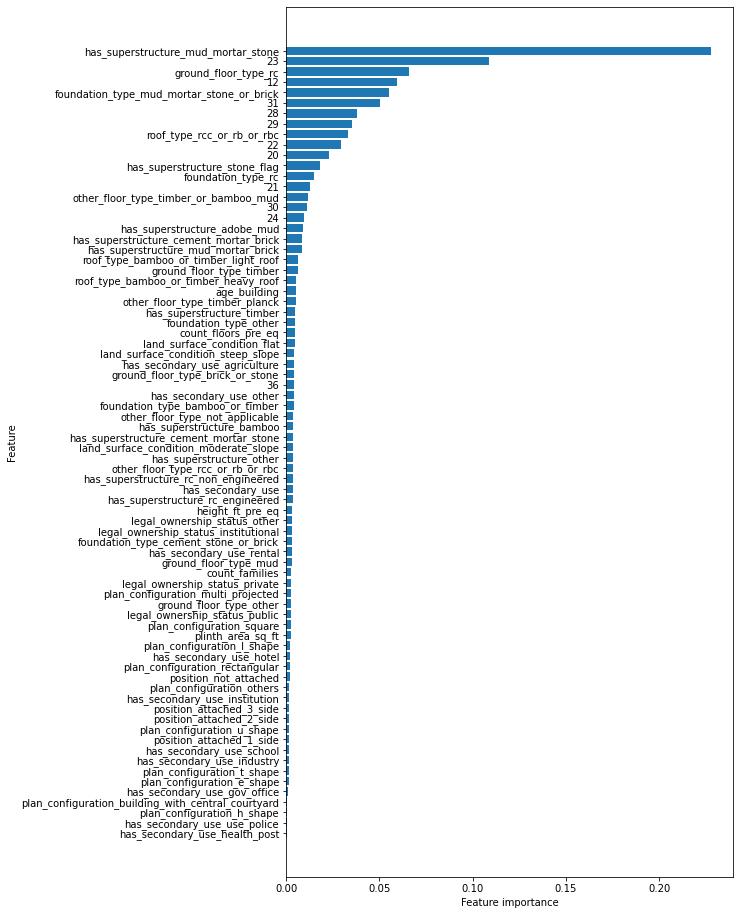

In [31]:
importance = []
feature_names = []

for i in sorted_features:
    feature_names.append(i[0])
    importance.append(i[1])
    
plt.figure(figsize=(8, 16))
n_features = X_train_scaled.shape[1]    
plt.barh(range(n_features), importance)
plt.yticks(np.arange(n_features), feature_names)
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

In [43]:
print('Classification Report for xgbc3, Validation Data','\n',
      '======================================================','\n',
      classification_report(y_val, xgbc3.predict(X_val_scaled)))

Classification Report for xgbc3, Validation Data 
               precision    recall  f1-score   support

         1.0       0.66      0.68      0.67     33118
         2.0       0.31      0.53      0.39     27409
         3.0       0.87      0.66      0.75     91892

    accuracy                           0.64    152419
   macro avg       0.61      0.63      0.60    152419
weighted avg       0.72      0.64      0.67    152419



In [36]:
print('Classification Report for xgbc3, Train Data','\n',
      '======================================================','\n',
      classification_report(y_tr_res, xgbc3.predict(X_train_scaled)))

Classification Report for xgbc3, Train Data 
               precision    recall  f1-score   support

         1.0       0.73      0.71      0.72     81857
         2.0       0.55      0.57      0.56     81857
         3.0       0.69      0.68      0.68     81857

    accuracy                           0.65    245571
   macro avg       0.65      0.65      0.65    245571
weighted avg       0.65      0.65      0.65    245571



In [37]:
print('Classification Report for xgbc3, Test Data','\n',
      '======================================================','\n',
      classification_report(y_test, xgbc3.predict(X_test_scaled)))

Classification Report for xgbc3, Test Data 
               precision    recall  f1-score   support

         1.0       0.66      0.69      0.67     33245
         2.0       0.31      0.54      0.39     27146
         3.0       0.87      0.66      0.75     92028

    accuracy                           0.64    152419
   macro avg       0.61      0.63      0.60    152419
weighted avg       0.72      0.64      0.67    152419



Marginal difference is seen between the results from vanilla and the second model. 

We will try out another iteration with `n_estimators=600` and `max_depth=5` and see how the model performs

In [45]:
xgbc4 = xgboost.XGBClassifier(random_state=2015, objective='multi:softmax', num_class=3,
                             learning_rate=0.1, max_depth=5, n_estimators=600, verbosity=2)
xgbc4.fit(X_train_scaled, y_tr_res)

[18:35:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[18:35:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[18:35:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[18:35:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[18:35:48] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[18:35:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[18:35:49] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[18:35

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=600, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=2015, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=2)

In [47]:
print('Recall Score Class 3 Validation data: ', recall_score(y_val, xgbc4.predict(X_val_scaled), average=None)[2])

Recall Score Class 3 Validation data:  0.6626801027292909


In [46]:
print('Recall Score Class 3 Train data: ', recall_score(y_tr_res, xgbc4.predict(X_train_scaled), average=None)[2])

Recall Score Class 3 Train data:  0.6775352138485408


In [48]:
print('Recall Score Class 3 Test data: ', recall_score(y_test, xgbc4.predict(X_test_scaled), average=None)[2])

Recall Score Class 3 Test data:  0.6614182640066066


The scores did not change from our previous iteration, however, the model did take longer to run (~16mins when compared to )

In [50]:
xgbc5 = xgboost.XGBClassifier(random_state=2015, objective='multi:softmax', num_class=3,
                             learning_rate=0.05, max_depth=4, n_estimators=1000, verbosity=2)
xgbc5.fit(X_train_scaled, y_tr_res)

[19:05:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[19:05:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[19:05:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[19:05:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[19:05:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[19:05:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[19:05:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[19:05

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=2015, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=2)

In [51]:
print('Recall Score Class 3 Validation data: ', recall_score(y_val, xgbc5.predict(X_val_scaled), average=None)[2])

Recall Score Class 3 Validation data:  0.6460627693379184


In [53]:
print('Recall Score Class 3 Train data: ', recall_score(y_tr_res, xgbc5.predict(X_train_scaled), average=None)[2])

Recall Score Class 3 Train data:  0.6534444213689727
